# Reverse Engineering: check if center, scale and part work as I understand it

In [1]:
#import libraries
from matplotlib import pyplot as plt
import cv2
import h5py
import numpy as np

In [2]:
#read train hdf5 datasets
with h5py.File('/home/maxim/depth_dataset/train.h5', 'r') as hdf_train:
    center_train = np.array(hdf_train.get('center'))
    part_train = np.array(hdf_train.get('part'))
    scale_train = np.array(hdf_train.get('scale'))    
    
#names of top files
train_top_f = open('reverse_eng/train_top.txt', 'r') 
train_top_names = train_top_f.read().splitlines()


In [3]:
#indices of objects (matlab indices - 1):
classes_indexes_range = {"aeroplane": range(0,8), 
                         "bicycle": range(8,19), 
                         "boat": range(19,26), 
                         "bottle": range(26,33), 
                         "bus": range(33,45), 
                         "car": range(45,57), 
                         "chair": range(57,67), 
                         "sofa": range(67,77), 
                         "train": range(77,94), 
                         "tvmonitor": range(94,102)}

original image size: (375, 500, 3)
Pads (lrtb):9, 5, 5, 5
bbox corners (padded): (5, 14); (66, 76)
This is a boat
missing keypoint: 5
missing keypoint: 6
missing keypoint: 7


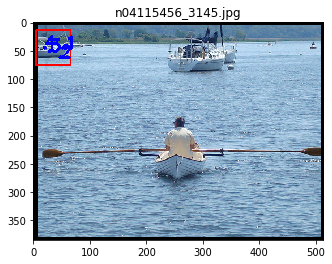

-------------------------------------------
original image size: (375, 500, 3)
Pads (lrtb):21, 5, 5, 39
bbox corners (padded): (5, 68); (350, 414)
This is a sofa
missing keypoint: 5


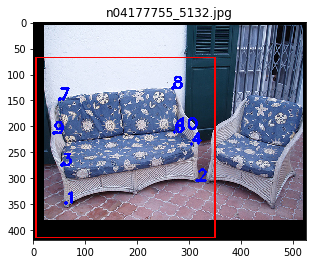

-------------------------------------------
original image size: (400, 500, 3)
Pads (lrtb):50, 51, 103, 98
bbox corners (padded): (5, 5); (596, 596)
This is a tvmonitor
missing keypoint: 5
missing keypoint: 7


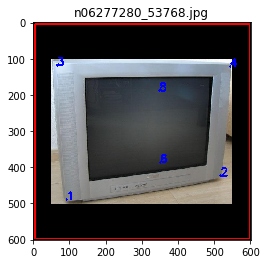

-------------------------------------------
original image size: (200, 300, 3)
Pads (lrtb):22, 16, 60, 78
bbox corners (padded): (5, 5); (333, 333)
This is a car
missing keypoint: 5
missing keypoint: 6


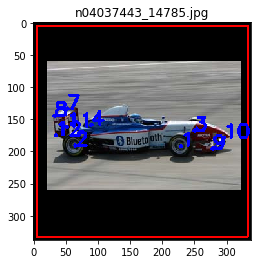

-------------------------------------------
original image size: (200, 400, 3)
Pads (lrtb):21, 22, 117, 126
bbox corners (padded): (5, 5); (438, 438)
This is a car


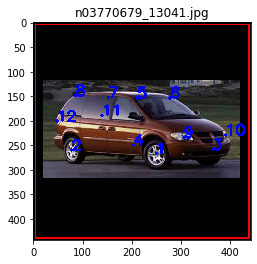

-------------------------------------------


In [4]:
for name in train_top_names:
    #index of image in the dataset
    idx = train_top_names.index(name)
    
    #read image in opencv
    img = cv2.imread('reverse_eng/images/'+name)
    img_colors = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #get image dimensions
    img_dimensions = img.shape
    print("original image size: "+str(img_dimensions))
    
    #compute bounding box coordinates (on unpadded image)
    start_point_bb_nopad = ((int)(center_train[idx][0]-scale_train[idx]*100), (int)(center_train[idx][1]-scale_train[idx]*100)) 
    end_point_bb_nopad = ((int)(center_train[idx][0]+scale_train[idx]*100), (int)(center_train[idx][1]+scale_train[idx]*100)) 
    #print("bbox corners: "+str(start_point_bb_nopad)+"; "+str(end_point_bb_nopad))
    
    #draw bounding box on unpadded image
    img_colors_rect_nopad = cv2.rectangle(img_colors, start_point_bb_nopad, end_point_bb_nopad, (255, 0, 0), 2)
    
    #compute padds
    margin = 5
    left_pad, right_pad, top_pad, bottom_pad = margin, margin, margin, margin
    if start_point_bb_nopad[0] < 0:
        left_pad = -start_point_bb_nopad[0] + margin
    if end_point_bb_nopad[0] > img_dimensions[1]:
        right_pad = end_point_bb_nopad[0] - img_dimensions[1] + margin
    if start_point_bb_nopad[1] < 0:
        top_pad = -start_point_bb_nopad[1] + margin
    if end_point_bb_nopad[1] > img_dimensions[0]:
        bottom_pad = end_point_bb_nopad[1] - img_dimensions[0] + margin
        
    print("Pads (lrtb):"+str(left_pad)+", "+str(right_pad)+", "+str(top_pad)+", "+str(bottom_pad))
    
    
    img_padded = cv2.copyMakeBorder(img_colors, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, None, 0)
    
    #compute bounding box coordinates (on padded image)
    start_point_bb_padded = (start_point_bb_nopad[0]+left_pad, start_point_bb_nopad[1]+top_pad)
    end_point_bb_padded = (end_point_bb_nopad[0]+left_pad, end_point_bb_nopad[1]+top_pad)
    print("bbox corners (padded): "+str(start_point_bb_padded)+"; "+str(end_point_bb_padded))

    #draw bounding box on unpadded image
    img_colors_rect_padded = cv2.rectangle(img_padded, start_point_bb_padded, end_point_bb_padded, (255, 0, 0), 2)
    
    #check indexes, and find class of object
    object_class=""
    for class_indexes in classes_indexes_range:
        if not (part_train[idx][classes_indexes_range[class_indexes]]==np.full(part_train[idx][classes_indexes_range[class_indexes]].shape, -1.)).all():
            #print("This is a "+class_indexes)
            object_class=class_indexes
            break
    print("This is a "+object_class)
    
    #draw keypoints on image: 
    #print(part_train[idx][classes_indexes_range[class_indexes]])
    first_kp_id = classes_indexes_range[class_indexes][0]
    for kp_index in classes_indexes_range[class_indexes]:
        trans_kp_index = kp_index - first_kp_id + 1
        if (part_train[idx][kp_index]==np.full((2), -1.)).all():
            print("missing keypoint: "+str(trans_kp_index))
        else:
            kp_padded_np = part_train[idx][kp_index] + np.array([left_pad, top_pad])
            kp_padded = ((int)(kp_padded_np[0]), (int)(kp_padded_np[1]))
            cv2.circle(img_colors_rect_padded, kp_padded, 2, (0, 0, 255), thickness=2, lineType=8, shift=0)
            cv2.putText(img_colors_rect_padded, str(trans_kp_index), kp_padded, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
    #TODO take points one by one, if not -1 add to the image with the respective kp_index
    #TODO for i in 
    
    #plot image
    plt.imshow(img_colors_rect_padded)
    plt.title(name)
    plt.show()
    
    print("-------------------------------------------")

500
(-32, -59)
(521, 495)


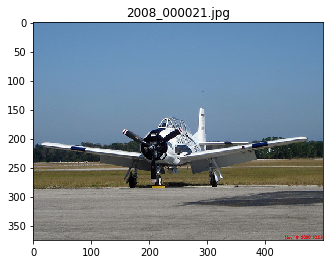

500
(-37, 81)
(413, 531)


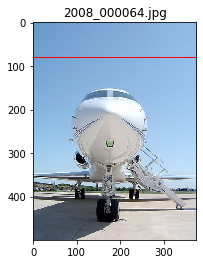

500
(-15, -102)
(449, 361)


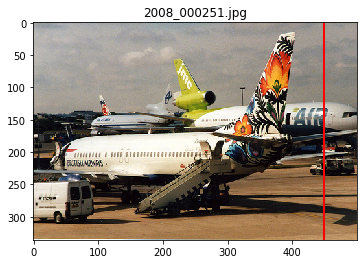

500
(-15, -102)
(449, 361)


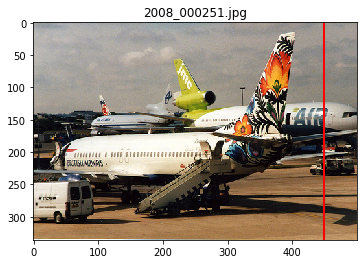

500
(-15, -102)
(449, 361)


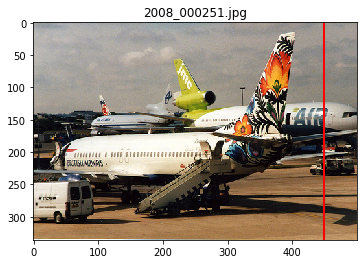

In [3]:
from matplotlib import pyplot as plt
import cv2
import h5py
import numpy as np


with h5py.File('/home/maxim/depth_dataset/valid.h5', 'r') as hdf_valid:
    center_valid = np.array(hdf_valid.get('center'))
    part_valid = np.array(hdf_valid.get('part'))
    scale_valid = np.array(hdf_valid.get('scale'))    


valid_top_f = open('reverse_eng/valid_top.txt', 'r') 
valid_top_names = valid_top_f.read().splitlines()
#print(valid_top_names)

for name in valid_top_names:
    idx = valid_top_names.index(name)
    #print(idx)
    
    img = cv2.imread('reverse_eng/images/'+name)
    img_colors = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dimensions = img.shape
    print(max(dimensions[0],dimensions[1]))
    start_point = ((int)(center_valid[idx][0]-scale_valid[idx]*100), (int)(center_valid[idx][1]-scale_valid[idx]*100)) 
    end_point = ((int)(center_valid[idx][0]+scale_valid[idx]*100), (int)(center_valid[idx][1]+scale_valid[idx]*100)) 
    print(start_point)
    print(end_point)
    img_colors = cv2.rectangle(img_colors, start_point, end_point, (255, 0, 0), 2)
    plt.imshow(img_colors)
    plt.title(name)
    plt.show()
    
